In [1]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
try: from importlib import reload
except ImportError: pass
%pylab inline

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


# Axially Symmetric Vortices

In this notebook, I will briefly review the theory required to implement an axially symmetric configuration for solving the BdG equations (later to be extended to the ASLDA).  The relevant code will be implemented in the file [`2D_vortex.py`](2D_vortex.py).

# Regulating the BdG

We start with the issue of regularization.  The $T=0$ equations in $d$ dimensions can be expressed in terms of the gap $\Delta$ and effective chemical potential $\mu_{\text{eff}} = \mu_0 + g_cn_+/2$ where $g_c>0$ represents an attractive interaction:

$$
  \Delta = g_c \nu_c, \qquad
  \epsilon_+ = \frac{\hbar^2k^2}{2m} - \mu_{\text{eff}}, \qquad
  \mathcal{E} = \frac{E}{V} 
              = \frac{\hbar^2\tau_c}{2m} - g_c(n_an_b+\nu_c^\dagger\nu_c)
              = \frac{\hbar^2\tau_c}{2m} - \Delta^\dagger\nu_c - \frac{(\mu_{\text{eff}} - \mu_0)n_+}{2},
$$

through the following integrals:
  
\begin{align}
  \nu_c &= \int_{c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{\Delta}{2\sqrt{\epsilon_+^2 + \Delta^2}}
  &&\sim \int_{c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{m\Delta}{\hbar^2 k^2},\\
  \tau_c &= \int_c\frac{\d^d{k}}{(2\pi)^d}\; k^2
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  &&\sim \int_c\frac{\d^d{k}}{(2\pi)^d}\; 
  \frac{2m^2\abs{\Delta}^2}{\hbar^4 k^2},\\
  n_+ &= \int_c\frac{\d^d{k}}{(2\pi)^d}
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  &&\sim \int_c\frac{\d^d{k}}{(2\pi)^d}\; 
  \frac{2m^2\abs{\Delta}^2}{\hbar^4 k^4}.
\end{align}

In 1D, these converge, but in 2D and higher, the quantities $\tau_c$ and $\nu_c$ diverge as $\ln(k_c)$ in 2D and as $k_c$ in 3D.  The density $n_+$ converges in both 2D and 3D, although slower in 3D.  Note that the divergence in $\tau_c$ and $\nu_c$ cancel in the combination

\begin{align}
  \kappa_c &=\int_c\frac{\d^d{k}}{(2\pi)^d}\;\left(\frac{\hbar^2\tau_c}{2m} - \Delta^\dagger \nu_c\right) 
  &&\sim \int_c\frac{\d^d{k}}{(2\pi)^d}\;\frac{2m^2\abs{\Delta}^2\mu_{\text{eff}}}{\hbar^4 k^4},
\end{align}

which enters the energy density $\mathcal{E}$.

To regularize the theory, we must define some finite physical quantity.  We express this as follows (see [Bulgac:2011] Eq. (84) but note that our $g_c$ has the opposite sign, and we consider only unit effective mass $\alpha_+ = 1$):

\begin{align}
  \tilde{C}(n_a, n_b) &= \overbrace{- \frac{\nu_c}{\Delta}}^{-\frac{1}{g_c}} + \overbrace{\frac{1}{2}\int_c \frac{\d^d{k}}{(2\pi)^d} \frac{1}{\epsilon_+ + \I 0^+}}^{\Lambda_c} = \frac{-1}{g_c} + \Lambda_c
  &&\sim \int_c \frac{\d^d{k}}{(2\pi)^d} \frac{2m^3\abs{\Delta}^2}{\hbar^6 k^6}.
\end{align}

where the integral is take in the principal value sense.  We include the chemical potential in the integral as advocated in [BY:2002fk].  This does not change the result in the limit $k_c \rightarrow \infty$ but shifts the finite portion to improve convergence.  Without this shift, the integral would behave as $\tilde{C} \sim -\int_c\d^d{k}\;2m^2\mu_{\text{eff}}/(2\pi)^d\hbar^4 k^4$.

For example, in 3D, the common Eagles-Leggett model fixes the regularization in terms of the two-body scattering length $a_s$:

$$
  \tilde{C}(n_a, n_b) = \frac{m}{4\pi \hbar^2 a_s}.
$$

The principal value integrals can be performed analytically, but the result is only independent of the pole location in 3D:

$$
  \Lambda_c^{1D} = \frac{m}{\hbar^2}\frac{1}{2\pi k_0}\ln\frac{k_c-k_0}{k_c+k_0}
  \rightarrow -\frac{m}{\hbar^2}\frac{1}{\pi k_c} \rightarrow 0,
  \\
  \Lambda_c^{2D} = \frac{m}{\hbar^2}\frac{1}{4\pi}
  \ln\left(\frac{k_c^2}{k_0^2}-1\right) 
  \rightarrow \frac{m}{\hbar^2}\frac{1}{2\pi}\ln\frac{k_c}{k_0},
  \\
  \Lambda_c^{3D} = \frac{m}{\hbar^2}\frac{k_c}{2\pi^2} 
  \left(1 - \frac{k_0}{2k_c}\ln\frac{k_c+k_0}{k_c-k_0}\right)
  \rightarrow \frac{m}{\hbar^2}\frac{k_c}{2\pi^2},
$$

where

$$
  \frac{\hbar^2k_0^2}{2m} - \mu = 0, \qquad
  \frac{\hbar^2k_c^2}{2m} - \mu = E_c.
$$

The latter equation allows us to replace the momentum cutoff $k_c$ in terms of an energy cutoff $E_c$ which is of use in inhomogeneous systems.

[BY:2002fk]: https://doi.org/10.1103/PhysRevLett.88.042504 'Aurel Bulgac and Yongle Yu, "Renormalization of the Hartree-Fock-Bogoliubov Equations in the Case of a Zero Range Pairing Interaction", prl 88(4), 042504 (2002) [nucl-th/0106062v3](http://arXiv.org/abs/nucl-th/0106062v3)'

[Bulgac:2011]: http://dx.doi.org/10.1007/978-3-642-21978-8_9 'Aurel Bulgac, Michael McNeil Forbes, and Piotr Magierski, "The Unitary Fermi Gas: From Monte Carlo to Density Functionals",  836, 305 -- 373 (2012) [1008.3933](http://arXiv.org/abs/1008.3933)'



## Thomas Fermi Completion

To facilitate convergence in the case when the solutions vary slowly, we can include states with $E>E_c$ by assuming that on length-scales smaller than $1/k_c$ the solution is homogeneous and performing the integrals.  This can be done excactly (numerically completing the integrals) or as a series approximation in $1/k_c$.  We include the leading order corrections here:

### 3D

$$
  n^{3D}_+ \approx \int_{E<E_c}\frac{\d^d{k}}{(2\pi)^d}
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  + \frac{m^2\abs{\Delta}^2}{k_c \hbar^4\pi^2}
  + \frac{4m^3\abs{\Delta^2}\mu}{3\hbar^6 \pi^2 k_c^3}
  + \order(k_c^{-5}),
  \\
  \kappa_c^{3D} \approx \int_{E<E_c}\frac{\d^d{k}}{(2\pi)^d}\;\left(\frac{\hbar^2\tau_c}{2m} - \Delta^\dagger \nu_c\right)
  + \frac{m^2 \mu \abs{\Delta}^2}{\hbar^4 \pi^2 k_c}
  + \frac{m^3\abs{\Delta}^2(8\mu^2-\abs{\Delta}^2)}{6\hbar^6\pi^2 k_c^3}
  +\order(k_c^{-5}),  
$$


In [4]:
import numpy as np
from scipy.integrate import quad
from uncertainties import ufloat

hbar = 1.
m = 1.

def n_integrand(k, mu, delta):
    ep = (hbar*k)**2/2/m - mu
    E = np.sqrt(ep**2 + abs(delta)**2)
    return (1 - ep/E)

def nu_integrand(k, mu, delta):
    ep = (hbar*k)**2/2./m - mu
    E = np.sqrt(ep**2 + abs(delta)**2)
    return delta/2/E

def tau_integrand(k, mu, delta):
    ep = (hbar*k)**2/2./m - mu
    E = np.sqrt(ep**2 + abs(delta)**2)
    return k**2*(1. - ep/E)

def E_integrand(k, mu, delta):
    tau = tau_integrand(k, mu=mu, delta=delta)
    nu = nu_integrand(k, mu=mu, delta=delta)
    #n = n_integrand(k, mu=mu, delta=delta)
    return hbar**2*tau/2/m - delta*nu

def C_integrand(k, mu, delta):
    """Integrand without chemical potential shift.
    
    This works better for numerical integration with infinite limits.
    """
    ep = (hbar*k)**2/2/m - mu
    return (0.5/(ep+1e-7j) - nu_integrand(k, mu=mu, delta=delta)/delta).real

def C0_integrand(k, mu, delta):
    """Integrand without chemical potential shift.
    
    This works better for numerical integration with infinite limits.
    """
    k0 = np.sqrt(2*m*mu)/hbar
    ep0 = (hbar*k)**2/2/m
    return (0.5/ep0 - nu_integrand(k, mu=mu, delta=delta)/delta).real

def integrate(integrand, mu, delta, k0=0, k_c=np.inf, d=3, **kw):
    if d == 1:
        f = lambda k: integrand(k, mu=mu, delta=delta)/np.pi
    elif d == 2:
        f = lambda k: integrand(k, mu=mu, delta=delta)*k/2/np.pi
    elif d == 3:
        f = lambda k: integrand(k, mu=mu, delta=delta)*k**2/2/np.pi**2
    return quad(f, k0, k_c, **kw)

def Lambda(k_c, mu, d=3):
    k_0 = np.sqrt(2*m*mu)/hbar
    if d == 3:
        return m/hbar**2 * k_c/2/np.pi**2*(
            1 - k_0/2/k_c*np.log((k_c+k_0)/(k_c-k_0)))
    elif d == 2:
        return m/hbar**2/4/np.pi * np.log((k_c/k_0)**2-1)
    
e_F = 1.0
k_F = np.sqrt(2*m*e_F)
n_F = k_F**3/3/np.pi**2
E_FG = 3./5*n_F*e_F
mu = 0.59060550703283853378393810185221521748413488992993*e_F
delta = 1.162200561790012570995259741628790656202543181557689*mu
delta = 0.68640205206984016444108204356564421137062514068346*e_F

kw = dict(mu=mu, delta=delta)
n_p = ufloat(*integrate(n_integrand, **kw))
assert np.allclose(n_p.n, k_F**3/3/np.pi**2)

C0 = ufloat(*integrate(C0_integrand, **kw))
assert np.allclose(C0.n, 0)

## 2D values
kw.update(d=2)
n2_p = ufloat(*integrate(n_integrand, **kw))
C2 = ufloat(*integrate(C0_integrand, **kw))
n2_p, C2

c:\program files\python36\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


(0.23811543349241718+/-4.201227618408804e-10,
 5.919094185814351+/-0.9929988554063527)

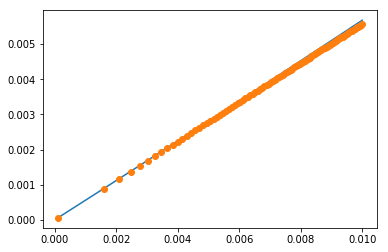

In [6]:
p = 5
ks = np.linspace(10.0**(-p),100**(-p),100)**(-1./p)
plt.plot(1./ks**2, ks**2*E_integrand(ks, mu=mu, delta=delta), '-')
plt.plot(1./ks**2, 2*delta**2*mu/ks**2, 'o')

In [7]:
((integrate(E_integrand, mu=mu, delta=delta, k0=0, k_c=10)[0]
  + integrate(E_integrand, mu=mu, delta=delta, k0=10, k_c=20)[0]
  + integrate(E_integrand, mu=mu, delta=delta, k0=20, k_c=np.inf)[0]),
 0.59060550703283853378393810185221521748413488992993*E_FG)

c:\program files\python36\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


(0.03369699187516921, 0.0338510961175258)

In [8]:
from scipy.special import hyp2f1
def P(n, x):
    return hyp2f1(-n,n+1,1,(1-x)/2.0)

def f(alpha, a):
    return -np.pi/np.sin(np.pi*alpha)*P(alpha, -a)

y_U = 0.65222953196994067235
p0 = np.sqrt(2*m*mu)
print(-p0**5*(f(5./2, y_U) 
        - y_U*f(3./2, y_U) 
        + 0.5*(1-y_U**2)*f(0.5, y_U))/y_U**(5./2)/8/np.pi**2, 
      0.59060550703283853378393810185221521748413488992993*E_FG)

5./4*(4./3)**(5./3)*((f(5./2, y_U) - y_U*f(3./2, y_U) + 0.5*(1-y_U**2)*f(0.5, y_U)) 
 / abs(f(3./2, y_U) - y_U*f(1./2, y_U))**(5./3))

0.033851096117525674 0.0338510961175258


-0.5906055070328357

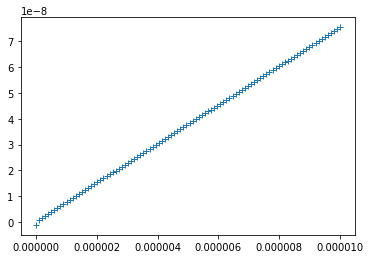

In [9]:
err = []
p = 5
ks = np.linspace(10.0**(-p),100**(-p),100)**(-1./p)
for k_c in ks:
    E = ufloat(*integrate(E_integrand, mu=mu, delta=delta, k_c=k_c))
    E_ = 0.59060550703283853378393810185221521748413488992993*E_FG
    err.append((E_ - E).n)
err = np.array(err)
dE = ((m/hbar**2)**2*mu*delta**2/np.pi**2/ks
      + (m/hbar**2)**3*delta**2 * (8*mu**2-delta**2)/6/np.pi**2/ks**3)
err -= dE
plt.plot(1./ks**p, err, '+')
#plt.plot(1./ks, dE+0*0.0038)
#plt.xlim(0, 0.1);plt.ylim(0, err.max());

In [10]:
integrate(C_integrand, k0=0, **kw)
kw
## 1D values
kw.update(d=1)
n1_p = ufloat(*integrate(n_integrand, **kw))
C1 = ufloat(*integrate(C0_integrand, **kw))
n1_p, C1

c:\program files\python36\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


(0.648482927322027+/-1.2260954683638914e-09,
 -0.8673082655551595+/-1.4104773016221372e-08)

The energy density is hard to compute because of roundoff error:

In [11]:
%pylab inline
E = np.linspace(0,2,100)
wp = E
wm = -E
h.T = 0.
plt.plot(E, 1 - h.f(-wm) - h.f(wp))
plt.plot(E, h.f(wm) - h.f(wp), '+')

Populating the interactive namespace from numpy and matplotlib


c:\program files\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


NameError: name 'h' is not defined

In [ ]:
k = np.linspace(0,2,100)
plt.plot(k, h._C0_integrand(k))
plt.plot(k, C0_integrand(k, mu=mu, delta=delta), '+')

In [ ]:
import homogeneous_mmf;reload(homogeneous_mmf)
h = homogeneous_mmf.Homogeneous(dim=2)
h.get_C0(mus=(mu, mu), delta=delta)
h.get_n_p(mus=(mu, mu), delta=delta)

In [ ]:
3*n_p*mu/5 - n_p*mu - E[0]

In [ ]:
E = ufloat(*integrate(E_integrand, mu=mu, delta=delta))
E

Here is how we would do it with the cutoff:

In [ ]:
k_c = 100.0
L3 = Lambda(k_c, mu=mu)
g_c = -1./(C0.n - L3)
assert np.allclose(g_c*integrate(nu_integrand, mu, delta, k_c=k_c)[0], delta)

## Lattice Regularization

When we perform the calculations on a lattice, we have a natural cutoff specified by the basis.  Unfortunately, one does not obtain uniform convergence as a function of this cutoff unless one is careful to choose it appropriately.  This is because the shell corrections do not converge.

## Hamiltonian

The simplest implementation explicitly forms the Hamiltonian matrix.  This is not ideal for larger systems, but is a quick way to check the code.  Here we show how to form the kinetic energy by using the FFT to compute the matrix $U$ that implements the FFT.

In [ ]:
Nx, Ny = 64, 64
H = np.eye(Nx*Ny).reshape(Nx, Ny, Nx, Ny)
U = np.fft.fftn(H, axes=[0,1]).reshape(Nx*Ny, Nx*Ny)
psi = np.random.random((Nx, Ny))
np.allclose(np.fft.fftn(psi).ravel(), U.dot(psi.ravel()))

In [ ]:
from importlib import reload
import vortex_2d;reload(vortex_2d)
s = vortex_2d.BCS(Nxy=(16,)*2)
k_c = abs(s.kxy[0]).max()
E_c = (s.hbar*k_c)**2/2/s.m
s = vortex_2d.BCS(Nxy=(16,)*2, E_c=E_c)
kw = dict(mus=(mu, mu), delta=delta)
#R = s.get_R(**kw)
H = s.get_H(**kw)
assert np.allclose(H, H.T.conj())

In [ ]:
plt.plot(E, s.f(E, E_c=np.inf))
plt.axvline(E_c, c='y')
plt.axvline(-E_c, c='y')

In [ ]:
E

In [ ]:
%pylab inline --no-import-all
Nx, Ny = s.Nxy
%time E, psi = np.linalg.eigh(H)
n = -3
u, v = psi[:, n].reshape(2, Nx, Ny)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.imshow(abs(u)**2);plt.colorbar()
plt.subplot(122);plt.imshow(abs(v)**2);plt.colorbar()
plt.suptitle(E[n]);

In [ ]:
R = s.get_R(**kw)
n_a = np.diag(R[:Nx*Ny,:Nx*Ny]).reshape(s.Nxy)
nu = np.diag(R[:Nx*Ny,Nx*Ny:]).reshape(s.Nxy)
n_b = 1 - np.diag(R[Nx*Ny:,Nx*Ny:]).reshape(s.Nxy)
n = n_a + n_b
assert np.allclose(n.imag, 0)
n = n.real
plt.imshow(n)
plt.colorbar()

In [ ]:
n.mean(), n_p

In [ ]:
gc = delta/nu.mean().real
gc, 1./(Lambda(k_c=k_c, mu=mu, d=2) - C2.n)

In [ ]:
nu.mean()

## Derivatives

In [32]:
%pylab inline
import numpy as np
N = 64
L = 2*np.pi
dx = L / N
x = np.arange(N) * dx - L / 2
k = 2*np.pi * np.fft.fftfreq(N, dx)
D = (-np.diag(np.ones(N)) + np.diag(np.ones(N-1), k=1))/dx
D[-1, 0] = 1./dx
D2 = -D.dot(D.T.conj())

Populating the interactive namespace from numpy and matplotlib


c:\program files\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


There is a sign error below.  Probably related to the shift $L/2$ but this needs to be be checked.

c:\program files\python36\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


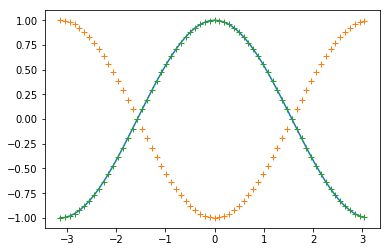

In [33]:
D = np.fft.ifft(-1j*k*np.fft.fft(np.eye(N), axis=1), axis=1)
f = np.sin(x)
plt.plot(x, np.cos(x))
plt.plot(x, np.fft.ifft(-1j*k*np.fft.fft(f)), '+')   # This minus sign seems wrong.  Why?
plt.plot(x, D.dot(f), '+')
D2 = -D.dot(D.T.conj())

c:\program files\python36\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


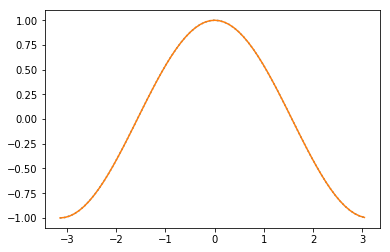

In [34]:
f = np.sin(x)
plt.plot(x, D.dot(f), ':')
plt.plot(x, np.cos(x))

c:\program files\python36\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


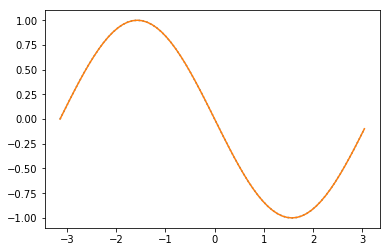

In [35]:
f = np.sin(x)
plt.plot(x, D2.dot(f), ':')
plt.plot(x, -np.sin(x))

$$
  \int\left(\alpha(x) \frac{\hbar^2}{2m}\tau(x) + D(n)\right)\d{x}
$$
$$
  E = \sum_x\alpha(x)|\nabla\psi(x)|^2\\
$$
$$
  E = \sum_x\alpha(x) \psi'(x){\psi^\dagger}'(x)
$$

$$
  \psi^\dagger\cdot D^\dagger \cdot A \cdot  D\cdot\psi\\
  K = D^\dagger \cdot A \cdot  D
$$

$$
  (A\psi')' = A' \psi' + A\psi''\\
  (A\psi)'' = (A'\psi + A\psi')' = (A''\psi + A\psi'' + 2 A'\psi')\\
 A'\psi' = \frac{(A\psi)'' - A''\psi - A\psi''}{2}\\
  (A\psi')' = \frac{(A\psi)'' - A''\psi + A\psi''}{2}
$$

$$
  (AB)' = A'B + AB'\\
  D\cdot(AB) = [D\cdot A]B + A[D\cdot B]
$$

In [36]:
# Numerical checks of the formula
%pylab inline
import numpy as np
N = 64
L = 2*np.pi
dx = L / N
x = np.arange(N) * dx - L / 2
k = 2*np.pi * np.fft.fftfreq(N, dx)
D = np.fft.ifft(-1j*k*np.fft.fft(np.eye(N), axis=1), axis=1)
D2 = -D.dot(D.T.conj())
alpha = np.exp(np.sin(x))
A = np.diag(alpha)
K = (A.dot(D2) - np.diag(D2.dot(alpha)) + D2.dot(A))/2
assert np.allclose(D2, D2.conj().T)
assert np.allclose(K, K.conj().T)

Populating the interactive namespace from numpy and matplotlib


c:\program files\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [37]:
np.allclose(K, K.conj().T)

True